In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import imutils
# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2 as cv
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

torch:  1.11 ; cuda:  1.11.0
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/1.11.0/torch1.11/index.html


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template
import pytesseract
import argparse
import imutils
import cv2
import cv2 as cv
import re
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [3]:
def pltshow(imgzz):
    plt.imshow(cv2.cvtColor(imgzz, cv2.COLOR_BGR2RGB))
    
def eqhist(img):
    return cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def getCanPipe(image, eqHist = False, blur = True, ):
    if eqHist:
        gray = eqhist(image)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if blur:
        blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
    else:
        blurred = gray
    edged = cv2.Canny(blurred, 100, 300)
    return edged

def sortCorners(corners):
    c = []
    idx = 0
    for i in corners.tolist():
        c.append(i[0])
        idx+=1
    c = sorted(c, key=lambda x:x[1])
    topones = [c[0], c[1]]
    bottomones = [c[2], c[3]]
    topones = sorted(topones, key = lambda x:x[0])
    topleft = topones[0]
    topright = topones[1]

    botones = sorted(bottomones, key = lambda x:x[0])
    bottomleft = botones[0]
    bottomright = botones[1]
    cornersz = [topleft, topright, bottomleft, bottomright]
    return cornersz

def getRect(edged):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    receiptCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            receiptCnt = approx
            # print(receiptCnt)
            break
    if receiptCnt is None:
        raise Exception(("No outline, oof"))
    return receiptCnt

def drawRect(image, rect):
    output = image.copy()
    cv2.drawContours(output, [rect], -1, (0, 255, 0), 2)
    pltshow(output)

def histeq(rgb_img):
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    return cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

def subtractMaskFromImg(img, mask1):
    mask2 = cv2.bitwise_not(mask1)
    return cv2.bitwise_and(img, img, mask = mask2)

def getMaskFromImg(img, mask):
    return cv2.bitwise_and(img, img, mask = mask)

In [4]:
plt.rcParams["figure.figsize"] = (15,15)

In [30]:
# imgs = [histeq(img) for img in imgs]
imgpath = "samples/check4.jpg"

orig = cv2.imread(imgpath)
image = orig.copy()
image = imutils.resize(image, width = 500) ## if the image does not have any humans, resize, else dont
ratio = orig.shape[1] / float(image.shape[1])

imagec = histeq(image)

cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(imagec)

v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# pltshow(out.get_image()[:, :, ::-1])

In [ ]:
def getDetectronOutput(image, dilateBy, iterations):
    """
    1 if 
    returns a cropped inamge of the check
    """
    # orig = cv2.imread(imgpath)
    
    # image = orig.copy()
    orig = image.copy()
    image = imutils.resize(image, width = 500) ## if the image does not have any humans, resize, else dont
    ratio = orig.shape[1] / float(image.shape[1])

    imagec = histeq(image)

    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)

    outputs = predictor(imagec)

    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    peopleMasks = []
    bookMasks = []
    isABookMask = False
    temp = outputs["instances"]

    if len(outputs["instances"].pred_classes) == 0: # nothing detected
        pass
    elif 73 in temp.pred_classes and 0 not in temp.pred_classes:
        print("Skip me, go straight to the next step")
    elif 73 in temp.pred_classes and 0 in temp.pred_classes:  # assuming only one book in the image
        bookmask = np.array(temp.pred_masks[list(temp.pred_classes).index(73)])
        indices = bookmask.astype(np.uint8)  #convert to an unsigned byte
        indices*=255
        kernel = np.ones((dilateBy,dilateBy), np.uint8)
        img_dilation = cv2.dilate(indices, kernel, iterations=1)
        bookMask = getMaskFromImg(imagec, img_dilation)
        imagec = bookMask
        imagec = getMaskFromImg(imagec, img_dilation)
        isABookMask = True
    else:  # lots of people in the img
        cntr = 0
        for i in list(temp.pred_classes):
            if i == 0 or i == 27 or i == 58:
                pplMask = np.array(temp.pred_masks[cntr])
                indices = pplMask.astype(np.uint8)
                indices*=255
                kernel = np.ones((3,3), np.uint8)
                # img_erosion = cv2.erode(indices, kernel)
                img_dilation = cv2.dilate(indices, kernel, iterations=1)
                imagec = subtractMaskFromImg(imagec, img_dilation)
            cntr += 1

In [ ]:
def getTemplate(tempPath, originalImage):
    img = imutils.resize(originalImage, width = 500)
    img2 = img.copy()
    template = cv.imread('samples/blankcheck2.jpg')
    wh = (329, 162)
    template = cv2.resize(template, wh)
    w, h = (template.shape[-2], template.shape[-3])
    methods = ['cv.TM_SQDIFF']
    for meth in methods:
        img = img2.copy()
        method = eval(meth)
        # Apply template Matching
        res = cv.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        top_left = min_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv.rectangle(mask,top_left, bottom_right, 255, -1)
        reverse = cv.bitwise_and(img, img, mask = mask)
        pltshow(reverse)

In [31]:
peopleMasks = []
bookMasks = []
isABookMask = False
temp = outputs["instances"]

if 73 in temp.pred_classes and 0 not in temp.pred_classes:
    print("Skip me, go straight to the next step")
elif 73 in temp.pred_classes and 0 in temp.pred_classes:  # assuming only one book in the image
    bookmask = np.array(temp.pred_masks[list(temp.pred_classes).index(73)])
    indices = bookmask.astype(np.uint8)  #convert to an unsigned byte
    indices*=255
    kernel = np.ones((7,7), np.uint8)
    img_dilation = cv2.dilate(indices, kernel, iterations=20)
    bookMask = getMaskFromImg(imagec, img_dilation)
    isABookMask = True
else:  # lots of people in the img
    cntr = 0
    for i in list(temp.pred_classes):
        if i == 0 or i == 27 or i == 58:
            pplMask = np.array(temp.pred_masks[cntr])
            indices = pplMask.astype(np.uint8)
            indices*=255
            kernel = np.ones((3,3), np.uint8)
            # img_erosion = cv2.erode(indices, kernel)
            img_dilation = cv2.dilate(indices, kernel, iterations=1)
            imagec = subtractMaskFromImg(imagec, img_dilation)
        cntr += 1
# pltshow(imagec)

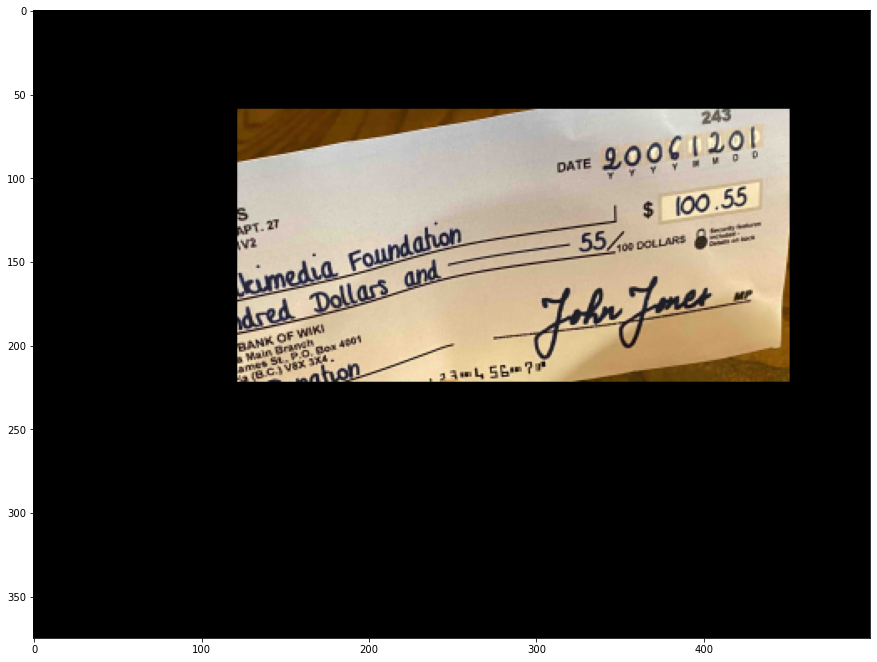

In [51]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = imutils.resize(cv.imread('samples/check3.jpg'), width = 500)
# img = cv2.cvtColor(imagec.copy(), cv2.COLOR_BGR2GRAY)
img2 = img.copy()
template = cv.imread('samples/blankcheck2.jpg')
wh = (329, 162)
template = cv2.resize(template, wh)
w, h = (template.shape[-2], template.shape[-3])
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#             'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
methods = ['cv.TM_SQDIFF']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv.rectangle(mask,top_left, bottom_right, 255, -1)
    reverse = cv.bitwise_and(img, img, mask = mask)
    pltshow(reverse)

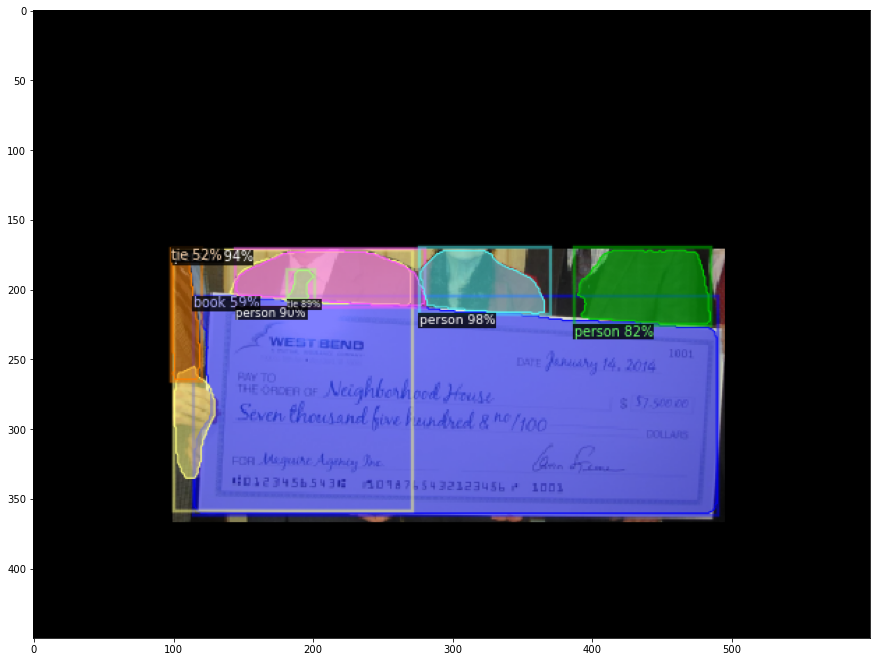

In [40]:
# imgpath = "samples/check4.jpg"

# orig = cv2.imread(imgpath)
orig = reverse
image = orig.copy()
image = imutils.resize(image, width = 500) ## if the image does not have any humans, resize, else dont
ratio = orig.shape[1] / float(image.shape[1])

imagec = histeq(image)

cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(imagec)

v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
pltshow(out.get_image()[:, :, ::-1])

HEHEHREHRE


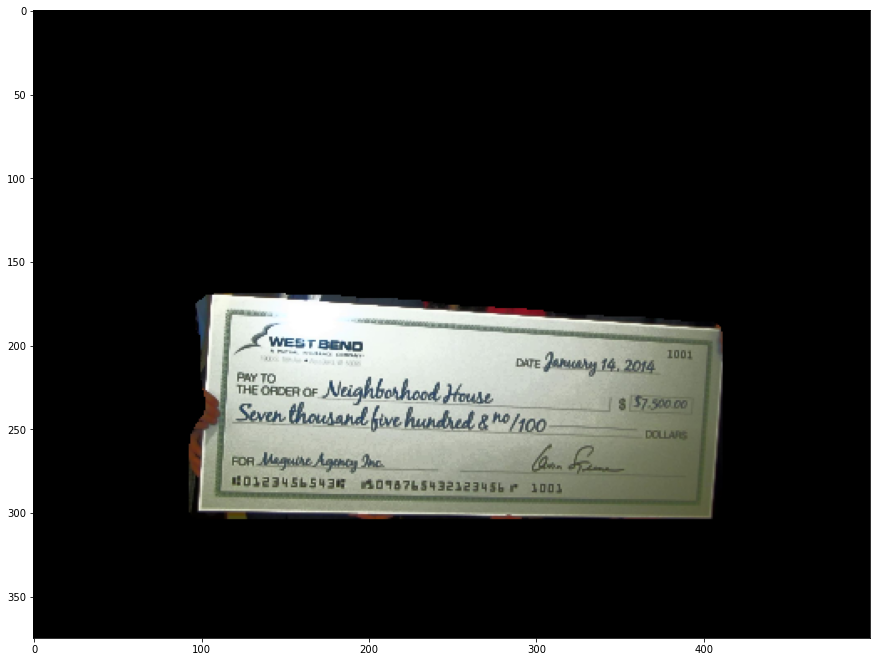

In [50]:
peopleMasks = []
bookMasks = []
isABookMask = False
temp = outputs["instances"]

if len(outputs["instances"].pred_classes) == 0: # nothing detected
    pass
elif 73 in temp.pred_classes and 0 not in temp.pred_classes:
    print("Skip me, go straight to the next step")
elif 73 in temp.pred_classes and 0 in temp.pred_classes:  # assuming only one book in the image
    print("HEHEHREHRE")
    bookmask = np.array(temp.pred_masks[list(temp.pred_classes).index(73)])
    indices = bookmask.astype(np.uint8)  #convert to an unsigned byte
    indices*=255
    kernel = np.ones((7,7), np.uint8)
    img_dilation = cv2.dilate(indices, kernel, iterations=1)
    bookMask = getMaskFromImg(imagec, img_dilation)
    imagec = bookMask
    imagec = getMaskFromImg(imagec, img_dilation)
    pltshow(imagec)
    isABookMask = True
else:  # lots of people in the img
    print("HI")
    cntr = 0
    for i in list(temp.pred_classes):
        if i == 0 or i == 27 or i == 58:
            pplMask = np.array(temp.pred_masks[cntr])
            indices = pplMask.astype(np.uint8)
            indices*=255
            kernel = np.ones((3,3), np.uint8)
            img_dilation = cv2.dilate(indices, kernel, iterations=1)
            imagec = subtractMaskFromImg(imagec, img_dilation)
        cntr += 1
# pltshow(imagec)

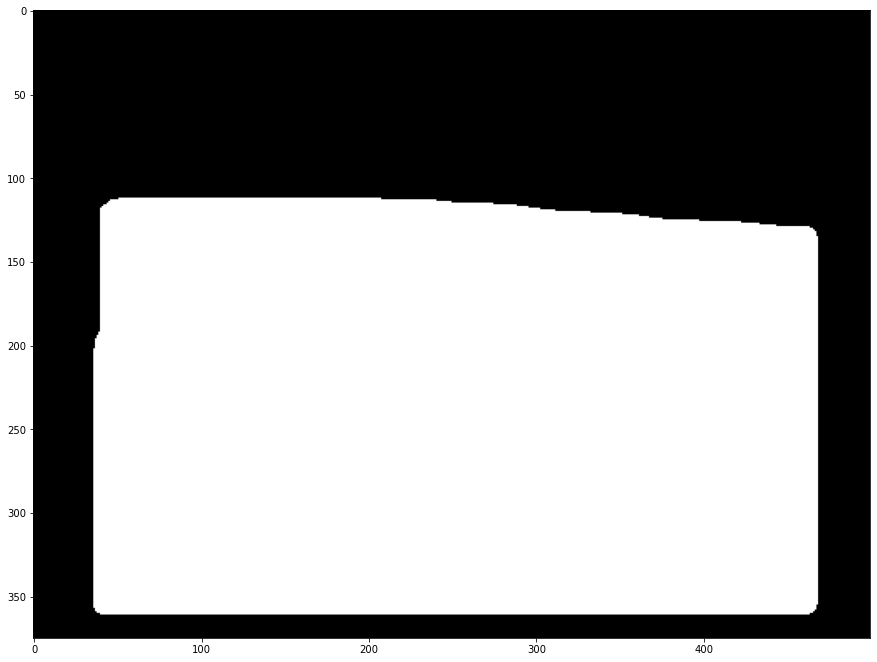

In [49]:
pltshow(img_dilation)